# Changing cwd

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('C:\\Users\\Usuario\\TFG\\digipanca\\')

# Checking window level

## Imports and functions

In [2]:
import numpy as np
import nibabel as nib
import torch
import matplotlib.pyplot as plt

In [3]:
def apply_window(image, window_level, window_width):
    """ Adjust the window level and window width for better visualization. """
    print(image)
    min_val = window_level - (window_width / 2)
    max_val = window_level + (window_width / 2)
    print(f"Min val: {min_val} | Max val: {max_val}")
    windowed_image = np.clip(image, min_val, max_val)
    print(windowed_image)
    return (windowed_image - min_val) / (max_val - min_val)

In [4]:
def vis(image, wimg):
    image = np.array(image.squeeze())
    wimg = np.array(wimg.squeeze())

    # Calcular la diferencia entre imágenes
    diff = np.abs(image - wimg)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Imagen CT original
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('CT Normal Image')
    axes[0].axis('off')
    
    # 2. Imagen CT con ventana aplicada
    axes[1].imshow(wimg, cmap='gray')
    axes[1].set_title('CT Windowed Image')
    axes[1].axis('off')

    # 3. Diferencia entre ambas imágenes
    axes[2].imshow(diff, cmap='hot')  # 'hot' para destacar diferencias
    axes[2].set_title('Difference (Original - Windowed)')
    axes[2].axis('off')

    plt.show()

    # Cálculos de diferencia
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    max_diff = np.max(diff)

    print(f'Difference Analysis:')
    print(f'  - Mean difference: {mean_diff:.4f}')
    print(f'  - Standard deviation: {std_diff:.4f}')
    print(f'  - Max difference: {max_diff:.4f}')

## Loading data and processing

In [12]:
path = 'data/raw/rtum35/SEQ/CTport-rtum35.nii'
image_nii = nib.load(path)
image = image_nii.get_fdata()
print(image.shape)
img_slice = image[:, :, 26]

(512, 512, 55)


In [13]:
im2 = img_slice.copy()
wimg = apply_window(im2, 50, 400)

[[-1024. -1024. -1024. ... -1024. -1024. -1024.]
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]
 ...
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]]
Min val: -150.0 | Max val: 250.0
[[-150. -150. -150. ... -150. -150. -150.]
 [-150. -150. -150. ... -150. -150. -150.]
 [-150. -150. -150. ... -150. -150. -150.]
 ...
 [-150. -150. -150. ... -150. -150. -150.]
 [-150. -150. -150. ... -150. -150. -150.]
 [-150. -150. -150. ... -150. -150. -150.]]


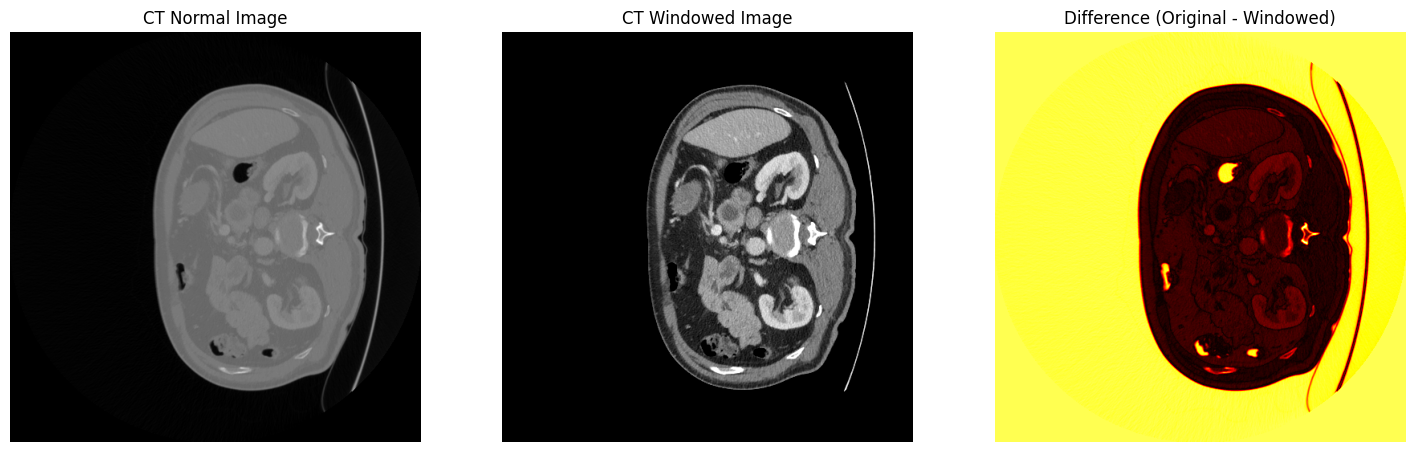

Difference Analysis:
  - Mean difference: 699.1952
  - Standard deviation: 430.9635
  - Max difference: 1240.0000


In [14]:
vis(img_slice, wimg)

In [8]:
print(img_slice)

[[-1024. -1024. -1024. ... -1024. -1024. -1024.]
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]
 ...
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]]


# Test affine

In [15]:
orientation = nib.aff2axcodes(image_nii.affine)
print(orientation)

('L', 'P', 'S')


In [45]:
from nibabel.orientations import io_orientation, axcodes2ornt, ornt_transform, apply_orientation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
def reorient_to_standard(image_path, target_orientation=('R', 'P', 'S')):
        """
        Reorient a NIfTI image to the target orientation in memory.

        Args:
            image_path (str): Path to the NIfTI image.
            target_orientation (tuple): Target orientation (e.g., ('R', 'A', 'S')).

        Returns:
            tuple: Reoriented image as numpy array, affine matrix.
        """
        image_nii = nib.load(image_path)

        # Detect current orientation
        current_orientation = io_orientation(image_nii.affine)

        # Define the target orientation
        target_orientation = axcodes2ornt(target_orientation)

        # Compute the transformation to the target orientation
        transform = ornt_transform(current_orientation, target_orientation)

        # Apply the orientation transformation
        reoriented_data = apply_orientation(image_nii.get_fdata(), transform)

        # Compute the new affine matrix
        new_affine = image_nii.affine @ nib.orientations.inv_ornt_aff(transform, image_nii.shape)

        return reoriented_data, new_affine

def visualize(image, mask, alpha=0.5, zoom=1.0):
    """
    Visualize a sample from the dataset with the segmentation mask overlay.

    Parameters
    ----------
    alpha : float, optional
        Transparency of the overlay (default: 0.5).
    zoom : float, optional
        Zoom factor for the cropped image (default: 1.0, max).
    """
    CMAP = mcolors.ListedColormap(['green', 'purple', 'red', 'blue'])
    BOUNDARIES = [0.5, 1.5, 2.5, 3.5, 4.5]
    NORM = mcolors.BoundaryNorm(BOUNDARIES, CMAP.N)
    # Convert to NumPy arrays
    image = np.array(image.squeeze())  # Remove channel dimension
    mask = np.array(mask)

    # Create a masked array for the segmentation mask (to ignore background)
    mask_no_bg = np.ma.masked_where(mask == 0, mask)

    # Crop the image and mask
    h, w = image.shape
    crop_h, crop_w = round(200 * zoom), round(150 * zoom)
    
    x_start, x_end = max(0, crop_h), min(h, h - crop_h)
    y_start, y_end = max(0, crop_w), min(w, w - crop_w)

    # Create a figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. CT image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f'CT Image')
    axes[0].axis('off')

    # 2. Overlay
    axes[1].imshow(image[x_start:x_end, y_start:y_end], 
                   cmap='gray', extent=[0, w, 0, h])
    axes[1].imshow(mask_no_bg[x_start:x_end, y_start:y_end],
                   cmap=CMAP, norm=NORM, alpha=alpha, extent=[0, w, 0, h])
    axes[1].set_title(f'Overlay')
    axes[1].axis('off')

    # 3. Segmentation mask
    axes[2].imshow(mask_no_bg[x_start:x_end, y_start:y_end],
                   cmap=CMAP, norm=NORM)
    axes[2].set_title(f'Segmentation Mask')
    axes[2].axis('off')

    # Add a colorbar with the segmentation classes
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    colorbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=NORM, cmap=CMAP),
                            cax=cbar_ax)
    colorbar.set_ticks([1, 2, 3, 4])
    colorbar.set_ticklabels(['Pancreas', 'Tumor', 'Arteries', 'Veins'])

    # Adjust the layout
    plt.subplots_adjust(wspace=0.4, right=0.9)
    plt.show()

In [46]:
rdata, raffine = reorient_to_standard(path)
print(rdata.shape)
mask_path = 'data/raw/rtum35/SEG/Pancreas-rtum35.nii'
rmdata, rmaffine = reorient_to_standard(mask_path)

(512, 512, 55)


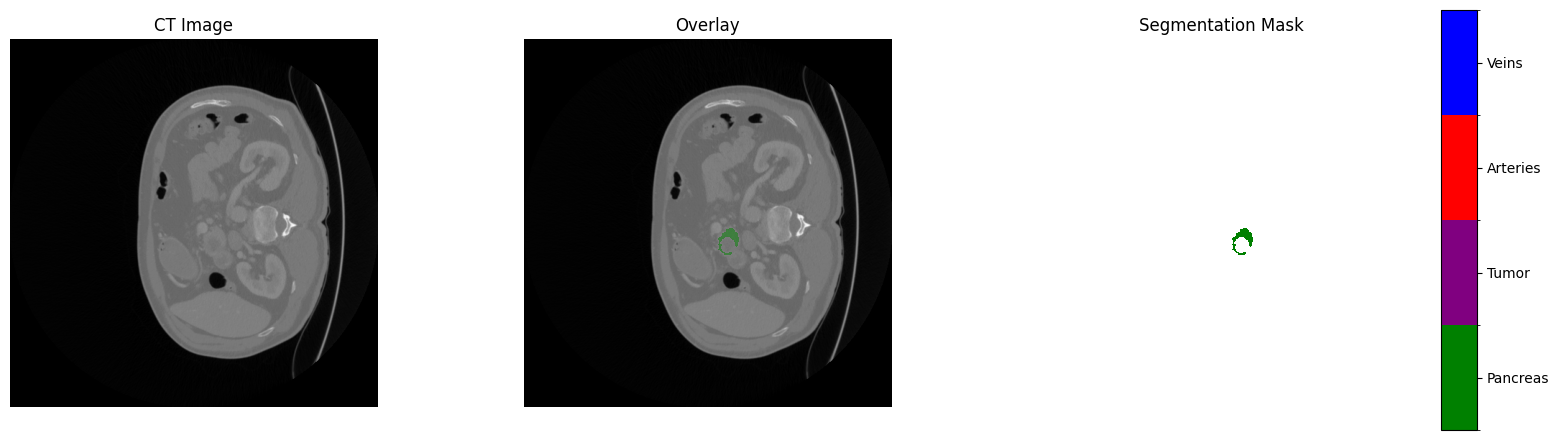

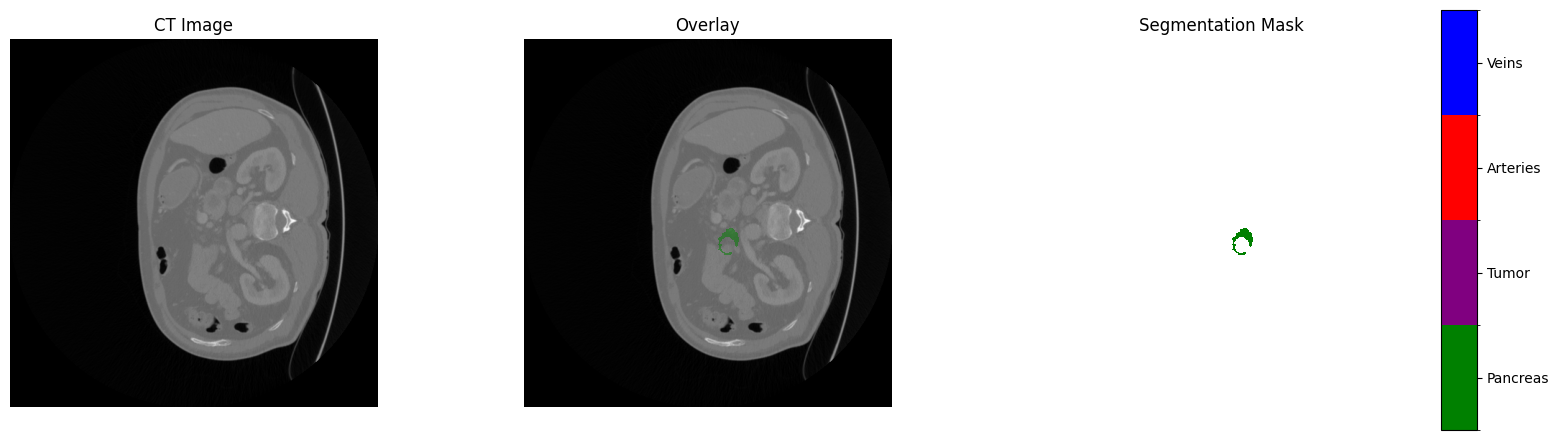

In [47]:
rimg = rdata[:, :, 28]
rmask = rmdata[:, :, 28]
visualize(rimg, rmask, zoom=0.0)
# print(rimg.shape)
i = image[:, :, 28]
visualize(i, rmask, zoom=0.0)